In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import yfinance as yf

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
df = yf.download('RELIANCE.NS', start='2020-01-01', end='2024-12-31')

[*********************100%***********************]  1 of 1 completed


In [ ]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
Date,,,,,
2020-01-01,672.876953,680.677278,671.049504,676.621114,14004468
2020-01-02,684.332275,686.850678,673.946719,673.946719,17710316
2020-01-03,685.156921,687.162718,678.849785,683.307097,20984698
2020-01-06,669.266541,681.033826,667.706464,677.512584,24519177
2020-01-07,679.562927,683.975667,674.615265,677.066781,16683622


In [ ]:
# Removing multilevel header (Removing Ticker and Reliance.NS)
df.columns = df.columns.droplevel(1)
df.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2020-01-01,672.876953,680.677278,671.049504,676.621114,14004468
2020-01-02,684.332275,686.850678,673.946719,673.946719,17710316
2020-01-03,685.156921,687.162718,678.849785,683.307097,20984698
2020-01-06,669.266541,681.033826,667.706464,677.512584,24519177
2020-01-07,679.562927,683.975667,674.615265,677.066781,16683622


In [ ]:
df.columns = [None] * len(df.columns) # removes the column names by resetting them to None
df.reset_index(inplace=True)

In [ ]:
df.columns = ['Date','Price', 'Close', 'High', 'Low', 'Volume']
df.head()

,Date,Price,Close,High,Low,Volume
0,2020-01-01,672.876953,680.677278,671.049504,676.621114,14004468
1,2020-01-02,684.332275,686.850678,673.946719,673.946719,17710316
2,2020-01-03,685.156921,687.162718,678.849785,683.307097,20984698
3,2020-01-06,669.266541,681.033826,667.706464,677.512584,24519177
4,2020-01-07,679.562927,683.975667,674.615265,677.066781,16683622


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1237 entries, 0 to 1236
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1237 non-null   datetime64[ns]
 1   Price   1237 non-null   float64       
 2   Close   1237 non-null   float64       
 3   High    1237 non-null   float64       
 4   Low     1237 non-null   float64       
 5   Volume  1237 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 58.1 KB


In [ ]:
from sklearn.preprocessing import MinMaxScaler

close_price = df['Close'].values.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0,1))
close_price_scaled = scaler.fit_transform(close_price)

In [ ]:
def data_sequence(data, sequence_length):
  X, y =[], []
  for i in range(len(data) - sequence_length):
    X.append(data[i:i+sequence_length])
    y.append(data[i+sequence_length])
  return np.array(X), np.array(y)

In [ ]:
sequence_length = 60
X, y = data_sequence(close_price_scaled, sequence_length)

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = Sequential()

model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

**Train the Model**

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0604
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0063
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0047
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0042
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0033
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0034
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0037
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0030
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0032
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0028


**Model Evaluation**

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

y_pred = model.predict(X_test)

y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = scaler.inverse_transform(y_pred)


mae = mean_absolute_error(y_test_rescaled,y_pred_rescaled)
rmse = math.sqrt(mean_squared_error(y_test_rescaled,y_pred_rescaled))

print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Mean Absolute Error: 31.89541233496957
Root Mean Squared Error: 38.57710517402902


On an average model predicted values are deviated by Rs 31.89 from the original value


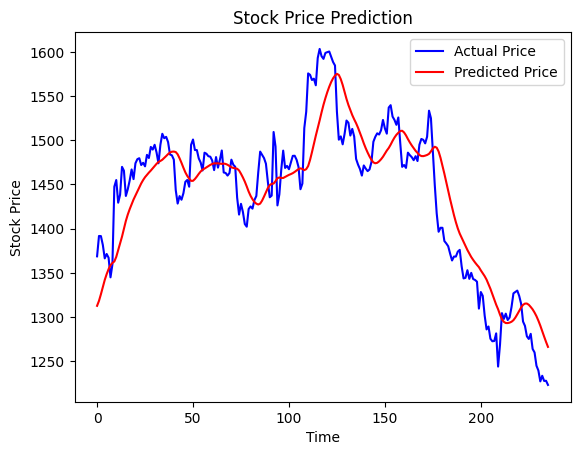

In [ ]:
import matplotlib.pyplot as plt

# Plotting the results
plt.plot(y_test_rescaled, color='blue', label='Actual Price')
plt.plot(y_pred_rescaled, color='red', label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
